# MA4270 Project by Chong Zhen Jie (A0201613Y)
___

# GLMs for Count Data

In [1]:
import numpy as np
from scipy.special import loggamma
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})

SEED = 4270

#### Generate synthetic negative binomial data.

In [2]:
np.random.seed(SEED)

# number of observations
nobs = 500
# dimension of input vector excluding constant term
dim = 2

# constant term
x0 = np.ones(nobs).reshape(1, -1)
# input matrix without constant term
x = np.random.normal(size = (dim, nobs))
# add constant term to input matrix
X = np.concatenate((x0, x)).T

# true theta
true_theta = np.array([1, 0.75, -1.25])
# linear predictor in matrix form
true_theta_x = X @ true_theta
# exp transformation
true_exp_theta_x = np.exp(true_theta_x)

# dispersion parameter
beta = 0.5
inv_beta = 1 / beta
# generate latent variable
h = np.random.gamma(beta, inv_beta, size = nobs)

# negative binomial linear predictor
true_h_exp_theta_x = h * true_exp_theta_x
# generate negative binomial data
nb_y = np.random.poisson(true_h_exp_theta_x)

#### Fit Poisson model and negative binomial model using Fisher scoring method.

In [3]:
# Fisher scoring method for both Poisson model and NB model
class Pois_NB:
    
    # inv_beta = 0 refers to Poisson model, while inv_beta > 0 refers to NB model
    def __init__(self, inv_beta = 0):
        self.inv_beta = inv_beta
        self.beta = 1/self.inv_beta if self.inv_beta!=0 else 0
    
    def fit(self, X, y, TOL = 10e-5):
        self.X = X
        self.y = y
        # initialize zero vector for theta estimates
        init_theta = np.zeros(self.X.shape[1])
        self.theta = init_theta
        # initialize linear predictor in matrix form
        theta_x = self.X @ self.theta
        # initialize exp transformation
        self.exp_theta_x = np.exp(theta_x)
        # initialize absolute change in log-likelihood, value does not matter as long as dloglik>TOL to start algorithm
        dloglik = np.inf
        # initialize log-likelihood value
        self.loglik = self.loglik_fn()
        # TOL = 10e-5 refers to tolerance level for stopping criterion
        while dloglik > TOL:
            # update rule for Fisher scoring
            self.theta = np.linalg.solve(self.expected_info(),
                                         self.expected_info() @ self.theta + self.score_fn())
            # update corresponding values below
            theta_x = self.X @ self.theta
            self.exp_theta_x = np.exp(theta_x)
            current_loglik = self.loglik_fn()
            dloglik = np.abs(self.loglik - current_loglik)
            self.loglik = current_loglik
        return self
    
    # score function
    def score_fn(self):
        u = ( (self.y-self.exp_theta_x) / (1+self.inv_beta*self.exp_theta_x) ) @ self.X
        return u
    
    # expected information matrix
    def expected_info(self):
        W = np.diag( self.exp_theta_x / (1+self.inv_beta*self.exp_theta_x) )
        F = self.X.T @ W @ self.X
        return F
    
    # log-likelihood function
    def loglik_fn(self):
        if self.inv_beta == 0:
            L = np.sum(
                self.y*np.log(self.exp_theta_x) -
                self.exp_theta_x - 
                loggamma(self.y+1) 
            )
            return L
        else:
            L = np.sum( 
                self.y*np.log((self.inv_beta*self.exp_theta_x)/(1+self.inv_beta*self.exp_theta_x)) -
                self.beta*np.log(1+self.inv_beta*self.exp_theta_x) +
                loggamma(self.y+self.beta) -
                loggamma(self.y+1) -
                loggamma(self.beta) 
            )
            return L
    
    # aic function
    def aic_fn(self):
        # negative binomial model has one additional parameter than the Poisson model, which is the dispersion parameter
        # np.sign acts as indicator function, outputs 0 for the Poisson model and 1 for the negative binomial model
        num_param = self.X.shape[1] + np.sign(self.inv_beta)
        aic = 2*num_param - 2*self.loglik
        return aic

In [4]:
# run Poisson regression
pois_model = Pois_NB().fit(X, nb_y)
pois_theta = pois_model.theta
pois_aic = pois_model.aic_fn()

print(pois_theta)
print(pois_aic)

[ 0.90959348  0.71347637 -1.3124301 ]
5986.612246344326


In [5]:
# run negative binomial regression
nb_model = Pois_NB(inv_beta).fit(X, nb_y)
nb_theta = nb_model.theta
nb_aic = nb_model.aic_fn()

print(nb_theta)
print(nb_aic)

[ 1.07878831  0.70509598 -1.12089505]
2193.1892079685504


#### Compare fitted values with actual data.

In [6]:
# compute fitted values
pois_fitted = np.exp(X @ pois_theta)
nb_fitted = np.exp(X @ nb_theta)

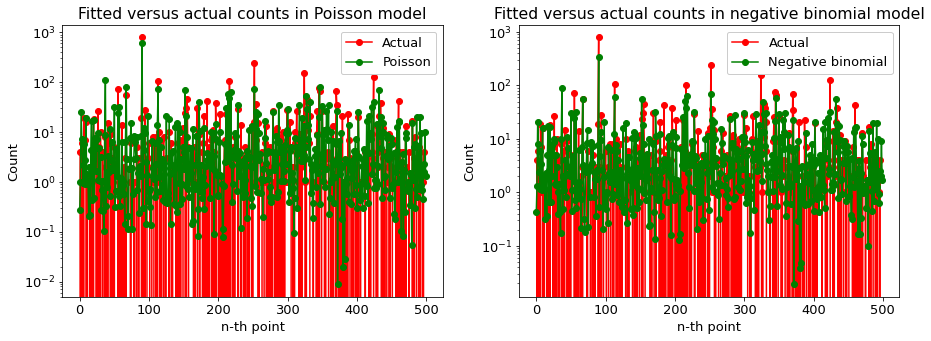

In [7]:
idx = range(len(nb_y))

# plot fitted vs actual counts
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(idx, nb_y, 'ro-', idx, pois_fitted, 'go-')
plt.yscale("log")
plt.ylabel("Count")
plt.xlabel("n-th point")
plt.title("Fitted versus actual counts in Poisson model")
plt.legend(["Actual", "Poisson"], loc = "upper right", framealpha = 1)

plt.subplot(1, 2, 2)
plt.plot(idx, nb_y, 'ro-', idx, nb_fitted, 'go-')
plt.yscale("log")
plt.ylabel("Count")
plt.xlabel("n-th point")
plt.title("Fitted versus actual counts in negative binomial model")
plt.legend(["Actual", "Negative binomial"], loc = "upper right", framealpha = 1)

plt.show()

---